In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from tqdm.auto import tqdm

import os
import glob

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

import copy

In [3]:
def plot_experiments(keys, experiment_dirs, 
                     labels_in=None,
                     x_post_process=None, y_post_process=None, 
                     x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=None):
    if x_post_process is None:
        x_post_fn = lambda x: x
    else:
        x_post_fn = x_post_process
        
    if y_post_process is None:
        y_post_fn = lambda x: x
    else:
        y_post_fn = y_post_process
    
    for ii, exp in enumerate(experiment_dirs):
        plot_kwargs = plot_kwargs_list[ii] if plot_kwargs_list is not None else {}
        
        data_path = os.path.join(results_root_dir, exp, 'filecoin_df.csv')
        df = pd.read_csv(data_path)

        if labels_in is not None:
            l = labels_in[ii]
        else:
            l = str(exp)
            
        if len(keys)==1:
            k = keys[0]
            x = x_post_fn(df[x_key])
            y = y_post_fn(df[k])
            plt.plot(x, y, label=l, **plot_kwargs)
        else:
            # get all keys and call the combine function
            key_data = {}
            for k in keys:
                key_data[k] = df[k]
            x = x_post_fn(df[x_key])
            y = y_post_fn(key_data)
            plt.plot(x, y, label=l, **plot_kwargs)
    
    plt.xticks(rotation=60)
    
def compute_available_fil_to_spend(key_data):
    available_FIL_to_spend = key_data['reward_FIL'].cumsum() \
                           - key_data['onboard_pledge_FIL'].cumsum() \
                           - key_data['renew_pledge_FIL'].cumsum() \
                           + key_data['onboard_scheduled_pledge_release_FIL'].cumsum() \
                           + key_data['renew_scheduled_pledge_release_FIL'].cumsum() \
                           + key_data['capital_inflow_FIL'].cumsum()
    return available_FIL_to_spend/1_000_000
    
def plot_agent_capital(experiment_dirs, labels_in, plot_kwargs_list=None):
    # aggregate over all agents 
    # read all of the agent infos into memory
    label2agentsinfo = {}
    for l, exp_dir in zip(labels_in, experiment_dirs):
        agent2agentinfo = {}
        agent2accountinginfo = {}
        flist = glob.glob(os.path.join(results_root_dir, exp_dir, '*.csv'))
        for fp in flist:
            fname = os.path.basename(fp)
            if 'filecoin_df' in fname:
                pass
            else:
                # parse the agent # from teh filename
                agent_num = int(fname.split('_')[1])
                if 'agent_info' in fname:
                    agent2agentinfo[agent_num] = pd.read_csv(fp)
                elif 'accounting' in fname:
                    agent2accountinginfo[agent_num] = pd.read_csv(fp)
        num_total_agents = len(agent2agentinfo)

        agent_total_df = pd.DataFrame()
        for ii in range(num_total_agents):
            agent_accounting_df = agent2accountinginfo[ii]
            available_FIL_to_spend = agent_accounting_df['reward_FIL'].cumsum() \
                                     - agent_accounting_df['onboard_pledge_FIL'].cumsum() \
                                     - agent_accounting_df['renew_pledge_FIL'].cumsum() \
                                     + agent_accounting_df['onboard_scheduled_pledge_release_FIL'].cumsum() \
                                     + agent_accounting_df['renew_scheduled_pledge_release_FIL'].cumsum() \
                                     + agent_accounting_df['capital_inflow_FIL'].cumsum()
            available_FIL_to_spend /= 1_000_000
            cc = 'agent_%d_FIL_spend' % (ii,)
            agent_total_df[cc] = available_FIL_to_spend
        total_spend_pattern = agent_total_df.sum(axis=1)
        return_df = pd.DataFrame()
        return_df['date'] = agent_accounting_df['date'] # only one of them but all should be the same
        return_df['FIL_spend_pattern'] = total_spend_pattern
        label2agentsinfo[l] = return_df
    
    for ii, l in enumerate(labels_in):
        plot_kwargs = plot_kwargs_list[ii] if plot_kwargs_list is not None else {}
        
        agent_info = label2agentsinfo[l]
        x = pd.to_datetime(agent_info['date'])
        y = agent_info['FIL_spend_pattern']
        
        plt.plot(x, y, label=l, **plot_kwargs)
            

In [18]:
simulation_start_date = date(2023, 2, 1)
num_agents=50
max_rbp_onboard_pib_day = 75
agent_type='farsighted'

results_root_dir='/Users/kiran/agentfil/exp/'
output_dir='/Users/kiran/Documents/hackmd/agentfil/'

experiment_dirs = [
    "maxrbponboard-%0.02f_nagents-%d_type-%s_optimism-2_maxpow-0.20_geometricdist" % 
        (max_rbp_onboard_pib_day, num_agents, agent_type),
    "maxrbponboard-%0.02f_nagents-%d_type-%s_optimism-2_maxpow-0.30_geometricdist" % 
        (max_rbp_onboard_pib_day, num_agents, agent_type),
    "maxrbponboard-%0.02f_nagents-%d_type-%s_optimism-2_maxpow-0.40_geometricdist" % 
        (max_rbp_onboard_pib_day, num_agents, agent_type),
#     "maxrbponboard-%0.02f_nagents-%d_type-%s_optimism-2_uniformpowerdist" % (max_rbp_onboard_pib_day, num_agents,),
    
    "maxrbponboard-%0.02f_nagents-%d_type-%s_optimism-4_maxpow-0.20_geometricdist" % 
        (max_rbp_onboard_pib_day, num_agents, agent_type),
    "maxrbponboard-%0.02f_nagents-%d_type-%s_optimism-4_maxpow-0.30_geometricdist" % 
        (max_rbp_onboard_pib_day, num_agents, agent_type),
    "maxrbponboard-%0.02f_nagents-%d_type-%s_optimism-4_maxpow-0.40_geometricdist" % 
        (max_rbp_onboard_pib_day, num_agents, agent_type),
#     "maxrbponboard-%0.02f_nagents-%d_type-%s_optimism-4_uniformpowerdist" % (max_rbp_onboard_pib_day, num_agents,),
    
    "maxrbponboard-%0.02f_nagents-%d_type-%s_optimism-proportional-min-1-max-5_maxpow-0.20_geometricdist" % 
        (max_rbp_onboard_pib_day, num_agents, agent_type),
    "maxrbponboard-%0.02f_nagents-%d_type-%s_optimism-proportional-min-1-max-5_maxpow-0.30_geometricdist" % 
        (max_rbp_onboard_pib_day, num_agents, agent_type),
    "maxrbponboard-%0.02f_nagents-%d_type-%s_optimism-proportional-min-1-max-5_maxpow-0.40_geometricdist" % 
        (max_rbp_onboard_pib_day, num_agents, agent_type),

]
labels = [
    'Geom-Opt2-MaxPow0.2',
    'Geom-Opt2-MaxPow0.3',
    'Geom-Opt2-MaxPow0.4',
#     'Unif-Opt2',
    
    'Geom-Opt4-MaxPow0.2',
    'Geom-Opt4-MaxPow0.3',
    'Geom-Opt4-MaxPow0.4',
#     'Uniform-Opt4',
    
    r'$Geom-\alpha[1,5]-0.2$',
    r'$Geom-\alpha[1,5]-0.3$',
    r'$Geom-\alpha[1,5]-0.4$',
]

experiment_names = experiment_dirs  # can rename for plot purposes

purples = mpl.colormaps['Purples']
blues = mpl.colormaps['Blues']
greens = mpl.colormaps['Greens']
oranges = mpl.colormaps['Oranges']
reds = mpl.colormaps['Reds']

vv = np.linspace(0.1, 0.9, 5)
lw=1.5
ff=0.5

plot_kwargs_list = [
    {'color': purples(ff), 'linewidth':lw, 'linestyle':':'},
    {'color': greens(ff), 'linewidth':lw, 'linestyle':':'},
    {'color': reds(ff), 'linewidth':lw, 'linestyle':':'},
#     {'color': oranges(ff), 'linewidth':lw, 'linestyle':'--'},

    {'color': purples(ff), 'linewidth':lw},
    {'color': greens(ff), 'linewidth':lw},
    {'color': reds(ff), 'linewidth':lw},
#     {'color': oranges(ff), 'linewidth':lw},
    
    {'color': purples(ff), 'linewidth':lw, 'linestyle':'--'},
    {'color': greens(ff), 'linewidth':lw, 'linestyle':'--'},
    {'color': reds(ff), 'linewidth':lw, 'linestyle':'--'},
]

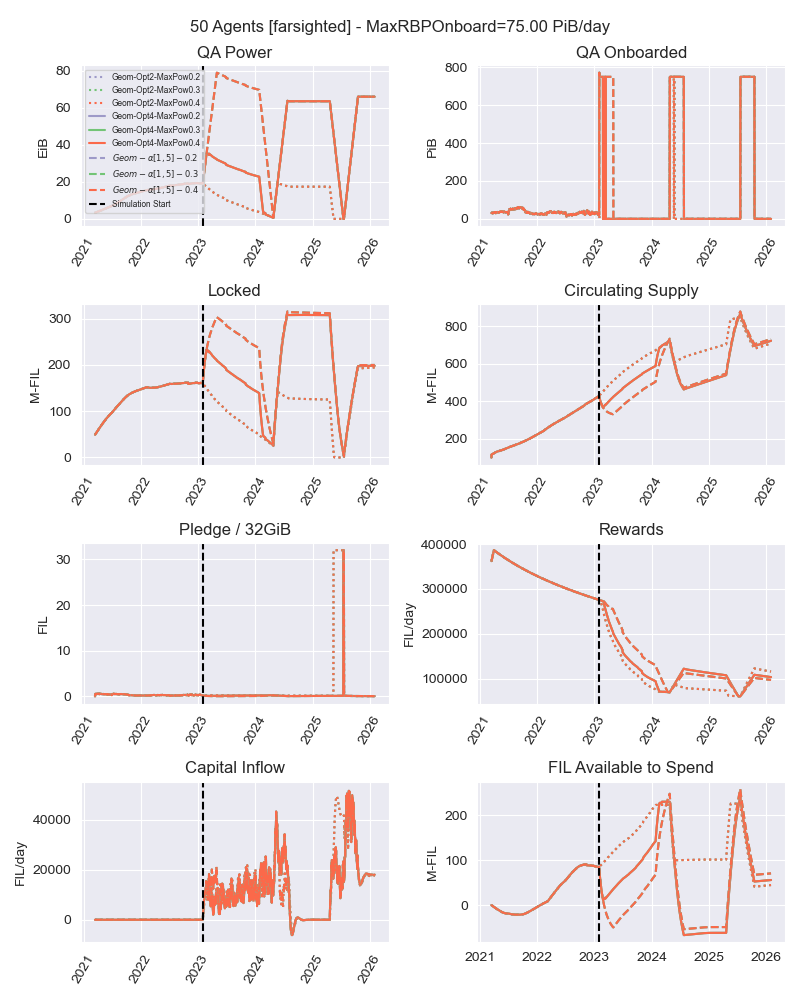

In [19]:
def x_post_fn(x_ser_in):
    x_ser_in = pd.to_datetime(x_ser_in)
    return x_ser_in
def y_post_fn(y_ser_in):
    y_ser_in /= 1_000_000
    return y_ser_in

plt.figure(figsize=(8,10))
plt.subplot(4,2,1)
plot_experiments(['total_qa_power_eib'], experiment_dirs, x_post_process=x_post_fn, labels_in=labels,
                plot_kwargs_list=plot_kwargs_list)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.legend(fontsize=6, loc='upper left')
plt.ylabel('EiB')
plt.title('QA Power')

plt.subplot(4,2,2)
plot_experiments(['day_onboarded_qap_pib'], experiment_dirs, x_post_process=x_post_fn, labels_in=labels,
                plot_kwargs_list=plot_kwargs_list)
plt.title('QA Onboarded')
plt.ylabel('PiB')

plt.subplot(4,2,3)
plot_experiments(['network_locked'], experiment_dirs, x_post_process=x_post_fn, y_post_process=y_post_fn, labels_in=labels,
                plot_kwargs_list=plot_kwargs_list)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('M-FIL')
plt.title('Locked')

plt.subplot(4,2,4)
plot_experiments(['circ_supply'], experiment_dirs, x_post_process=x_post_fn, y_post_process=y_post_fn, labels_in=labels,
                plot_kwargs_list=plot_kwargs_list)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('M-FIL')
plt.title('Circulating Supply')

plt.subplot(4,2,5)
plot_experiments(['day_pledge_per_QAP'], experiment_dirs, x_post_process=x_post_fn,
                plot_kwargs_list=plot_kwargs_list)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('FIL')
plt.title('Pledge / 32GiB')

plt.subplot(4,2,6)
plot_experiments(['day_network_reward'], experiment_dirs, x_post_process=x_post_fn,
                plot_kwargs_list=plot_kwargs_list)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('FIL/day')
plt.title('Rewards')

plt.subplot(4,2,7)
plot_experiments(['capital_inflow_FIL'], experiment_dirs, x_post_process=x_post_fn,
                plot_kwargs_list=plot_kwargs_list)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('FIL/day')
plt.title('Capital Inflow')

plt.subplot(4,2,8)
plot_agent_capital(experiment_dirs, labels, plot_kwargs_list=plot_kwargs_list)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('M-FIL')
plt.title('FIL Available to Spend')

plt.suptitle('%d Agents [%s] - MaxRBPOnboard=%0.02f PiB/day' % (num_agents,agent_type,max_rbp_onboard_pib_day))
plt.tight_layout()

output_fp='%d_agents_%s_maxrbponboard_%0.02f.png' % (num_agents, agent_type, max_rbp_onboard_pib_day)
plt.savefig(os.path.join(output_dir, output_fp))
plt.show()